In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import os

In [122]:
participant = '005'
path = f'epochs_2/{participant}/'

erp_data = np.load(f'{path}{participant}_erp_data.npz', allow_pickle=True)
erp_labels = np.load(f'{path}{participant}_erp_labels.npz', allow_pickle=True)

Delta = erp_data['Delta'].item()
Theta = erp_data['Theta'].item()
Alpha = erp_data['Alpha'].item()
Beta = erp_data['Beta'].item()
Gamma = erp_data['Gamma'].item()
High_gamma = erp_data['High-gamma'].item()

#put back in dict
pre_erps = {'Delta' : Delta, 'Theta' : Theta, 'Alpha' : Alpha, 'Beta' : Beta, 'Gamma' : Gamma, 'High-gamma' : High_gamma}

In [123]:
#convert erps from mne object to npy array
erps = {}
for band in pre_erps: 
    erps[band] = {}
    erps[band]['personal'] = pre_erps[band]['personal'].get_data()
    erps[band]['general'] = pre_erps[band]['general'].get_data()

Using data from preloaded Raw for 48 events and 1001 original time points ...
Using data from preloaded Raw for 52 events and 1001 original time points ...
Using data from preloaded Raw for 48 events and 1001 original time points ...
Using data from preloaded Raw for 52 events and 1001 original time points ...
Using data from preloaded Raw for 48 events and 1001 original time points ...
Using data from preloaded Raw for 52 events and 1001 original time points ...
Using data from preloaded Raw for 48 events and 1001 original time points ...
Using data from preloaded Raw for 52 events and 1001 original time points ...
Using data from preloaded Raw for 48 events and 1001 original time points ...
Using data from preloaded Raw for 52 events and 1001 original time points ...
Using data from preloaded Raw for 48 events and 1001 original time points ...
Using data from preloaded Raw for 52 events and 1001 original time points ...


In [124]:
#print(erps['Delta']['general'].get_data().shape[0])

#make sure all trials that will be compared are an equal number
for band in erps:
    n_trials = min(erps[band]['general'].shape[0], erps[band]['personal'].shape[0])
    erps[band]['general'] = erps[band]['general'][:n_trials]
    erps[band]['personal'] = erps[band]['personal'][:n_trials]


In [125]:
print(erps['Delta']['general'].shape, erps['Delta']['personal'].shape)

(48, 19, 1001) (48, 19, 1001)


In [126]:
#dependant ttest
n_channels, n_times = erps['Delta']['general'].shape[1], erps['Delta']['general'].shape[2]
stats = {}
t_stats = np.zeros((n_channels, n_times))
p_values = np.ones((n_channels, n_times))
for band in erps:
    stats[band] = {'t_stats' : t_stats ,'p_values': p_values  }

for band in erps:
    for ch in range(n_channels):
        for t in range(n_times):
            t_result = ttest_rel(erps[band]['personal'][:, ch, t], erps[band]['general'][:, ch, t])
            stats[band]['t_stats'][ch, t] = t_result.statistic
            stats[band]['p_values'][ch, t] = t_result.pvalue

In [127]:


#calculate means and stdev
mean_erps = {}
std_erps = {}
for band in erps:
    mean_erps[band] = {'personal' : np.mean(erps[band]['personal'], axis=0), 'general' : np.mean(erps[band]['general'], axis=0)} 
    std_erps[band] = {'personal' : np.std(erps[band]['personal'], axis=0), 'general': np.mean(erps[band]['general'], axis=0)}

print(mean_erps['Delta']['general'].shape)

(19, 1001)


[False False False ... False False False]
{'Delta': array([14,  8,  7,  3, 17]), 'Theta': array([14,  8,  7,  3, 17]), 'Alpha': array([14,  8,  7,  3, 17]), 'Beta': array([14,  8,  7,  3, 17]), 'Gamma': array([14,  8,  7,  3, 17]), 'High-gamma': array([14,  8,  7,  3, 17])}
channel: 14


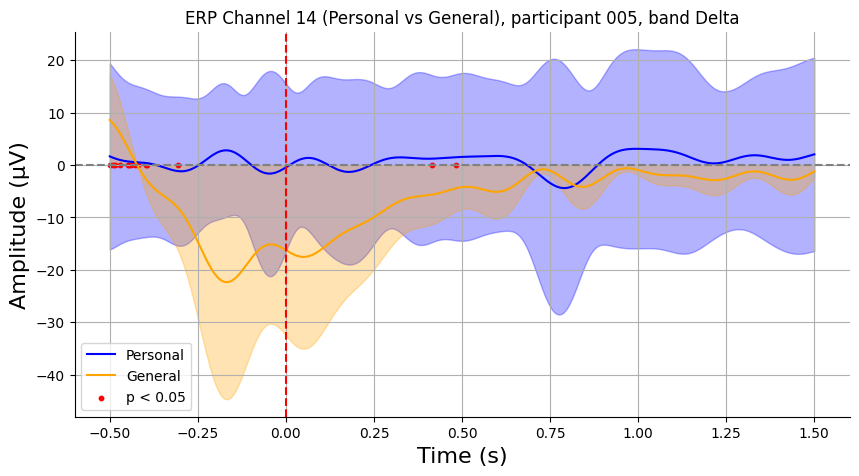

channel: 8


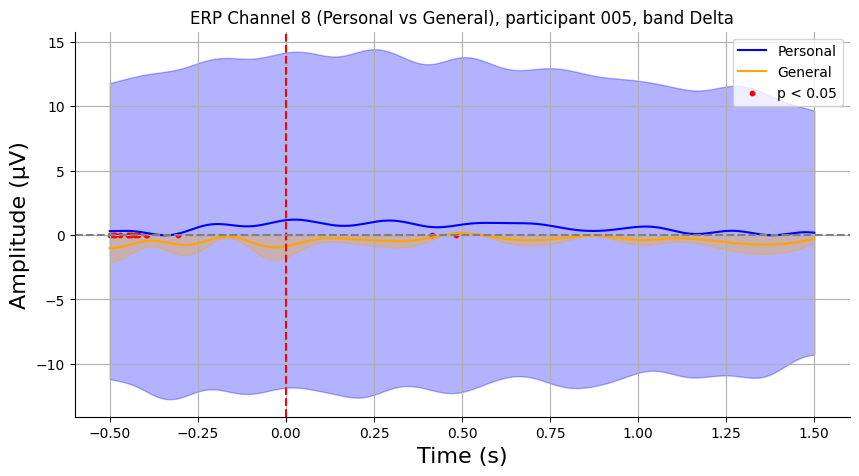

channel: 7


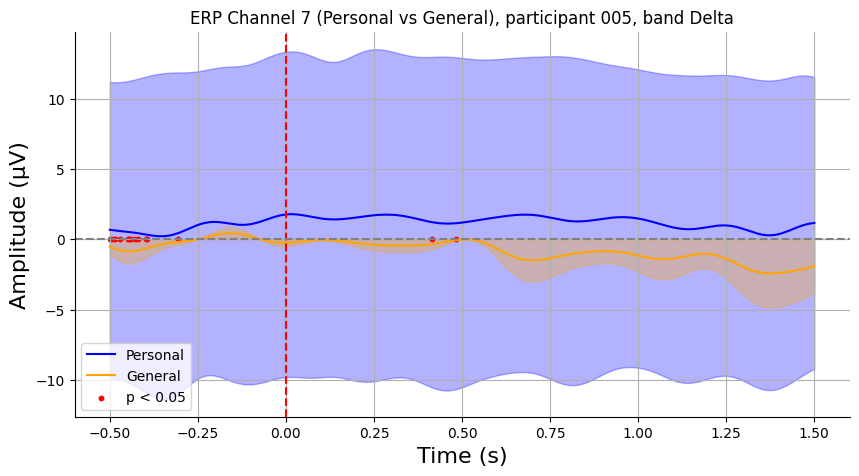

channel: 3


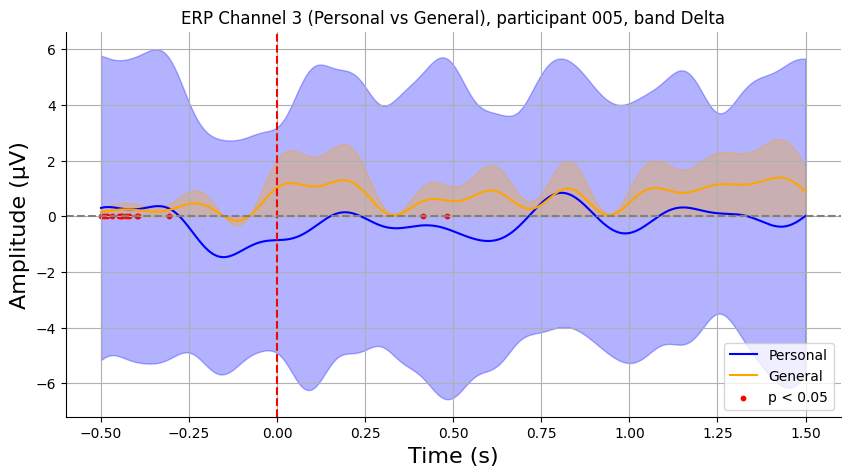

channel: 17


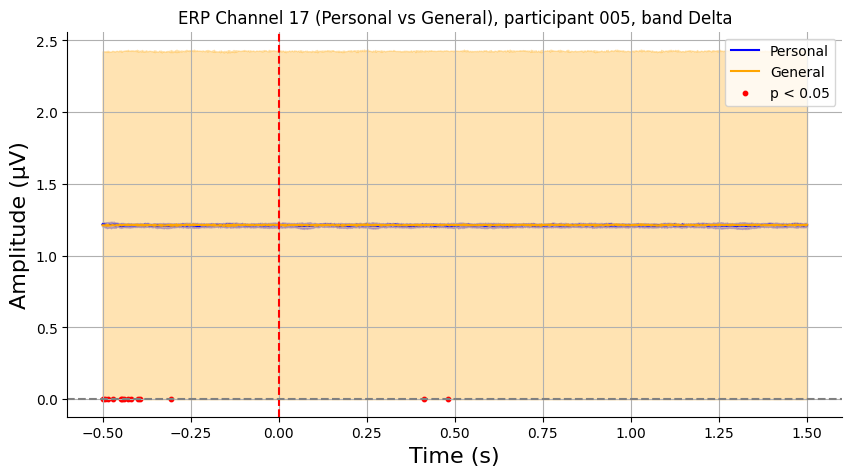

channel: 14


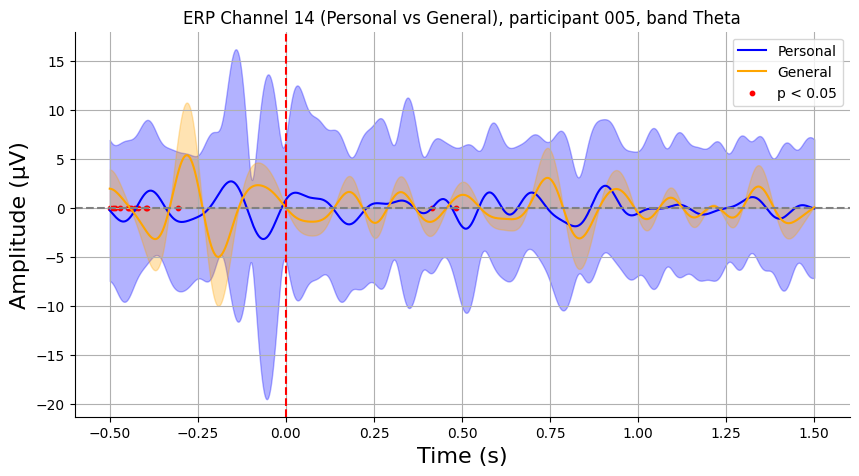

channel: 8


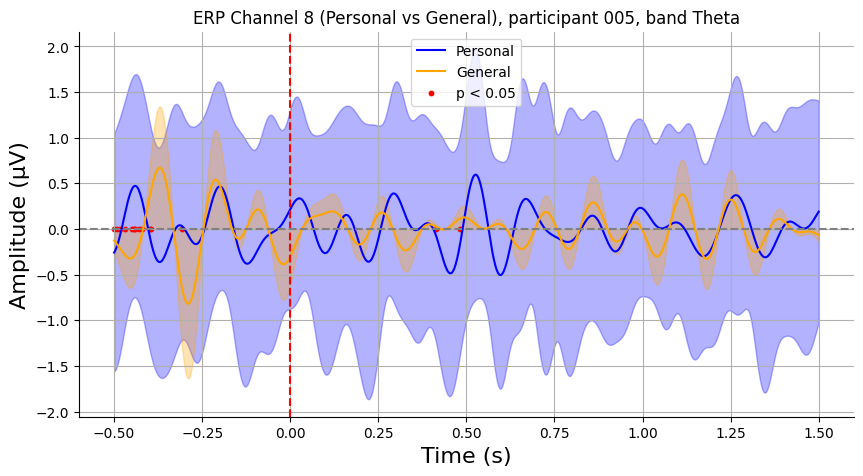

channel: 7


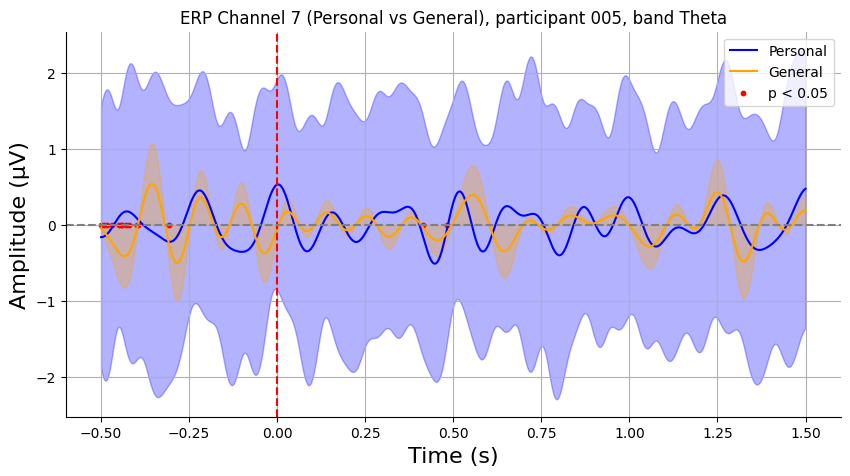

channel: 3


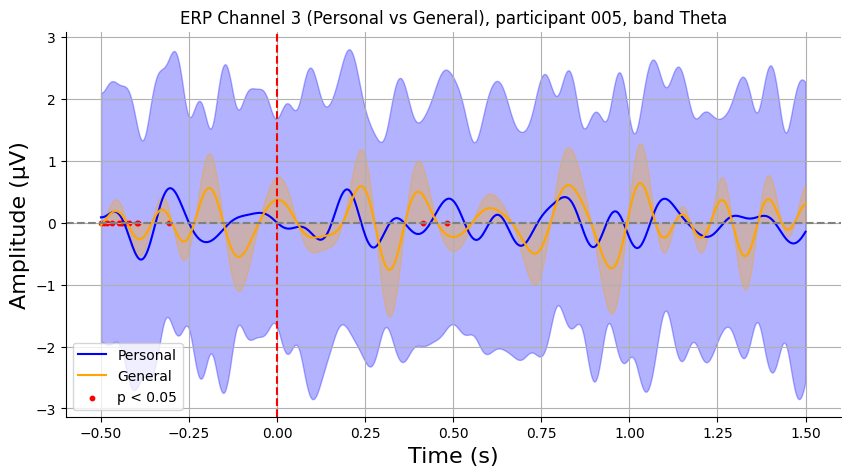

channel: 17


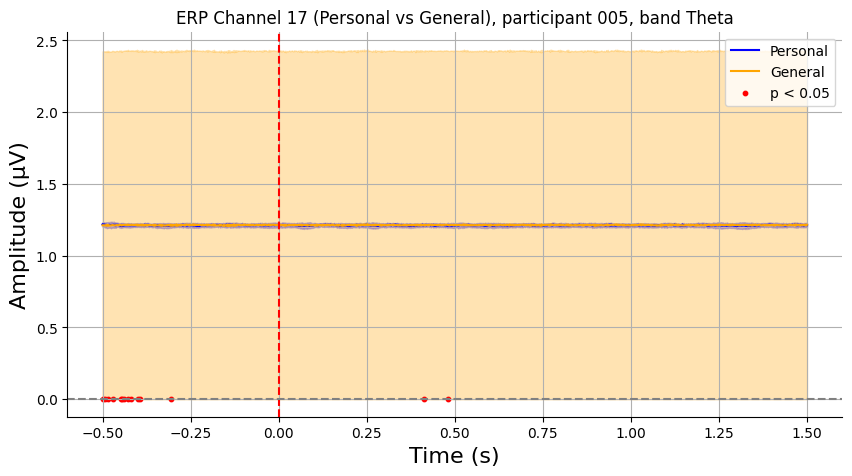

channel: 14


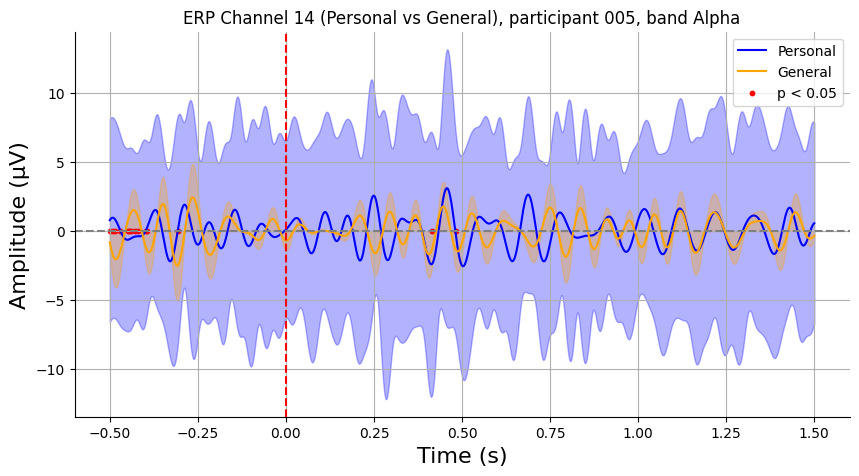

channel: 8


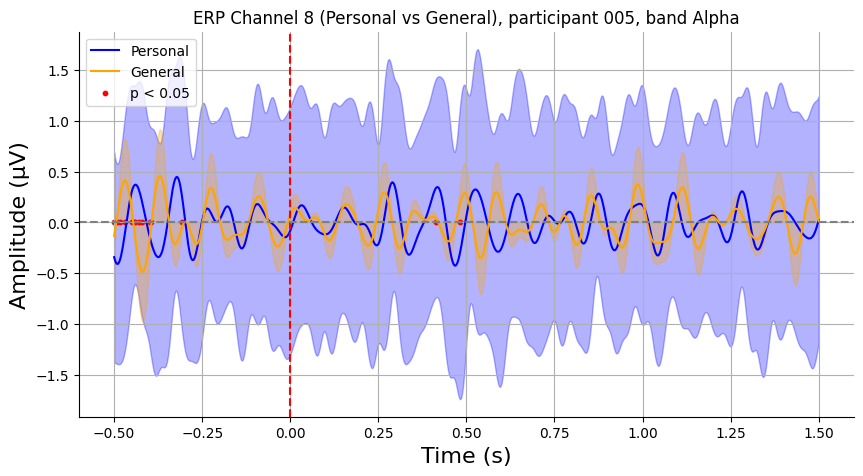

channel: 7


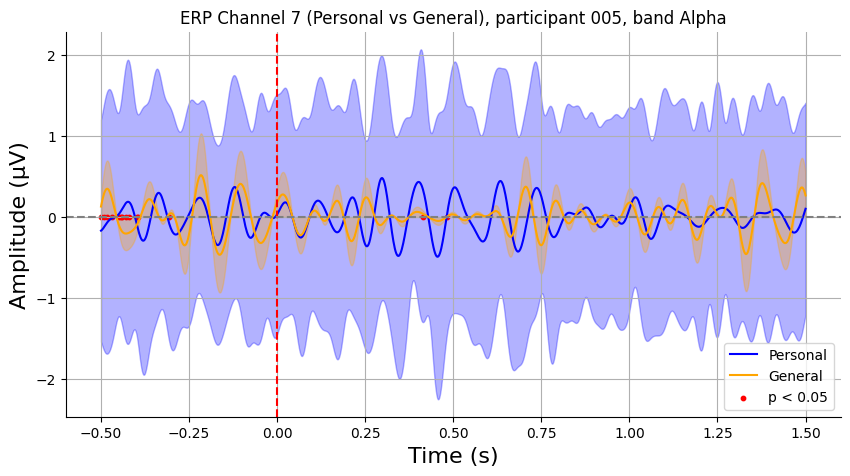

channel: 3


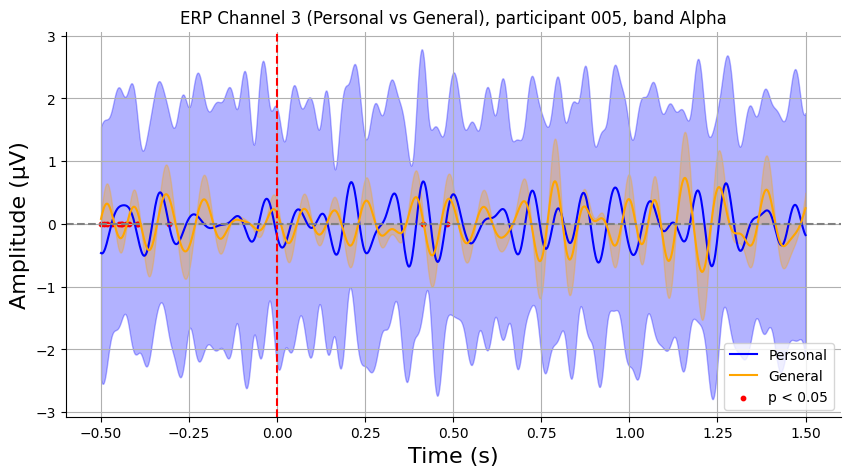

channel: 17


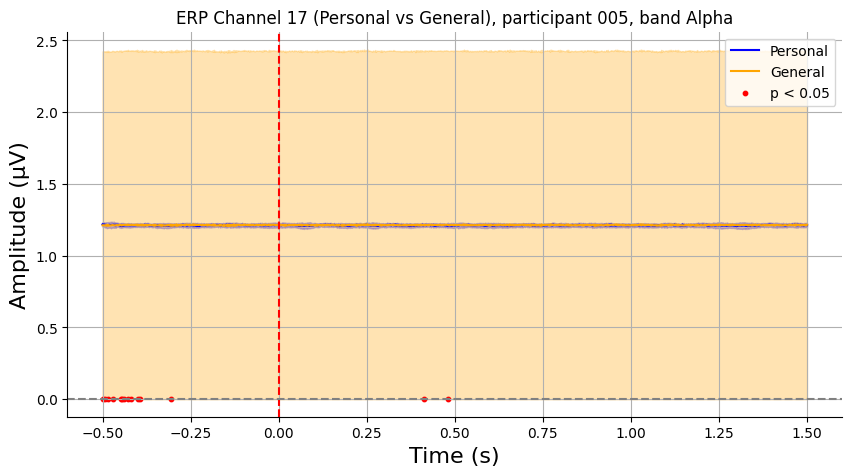

channel: 14


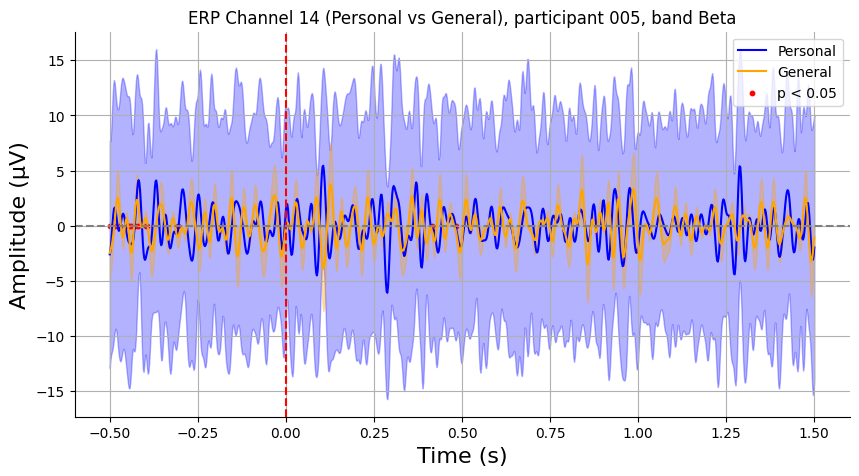

channel: 8


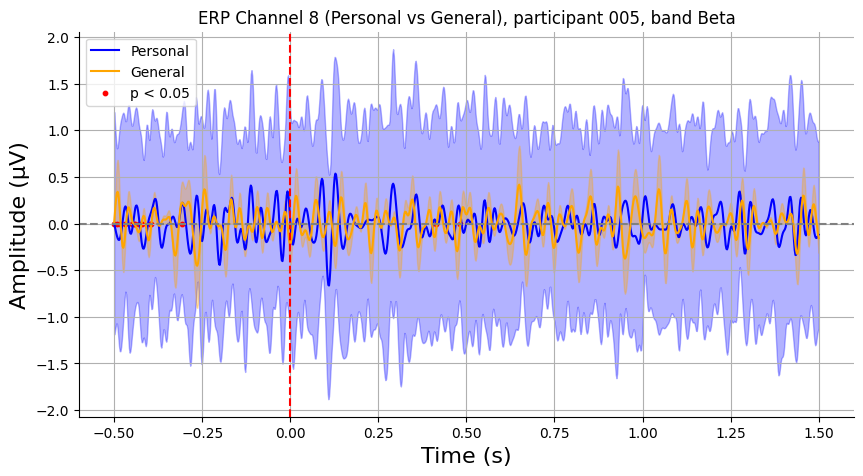

channel: 7


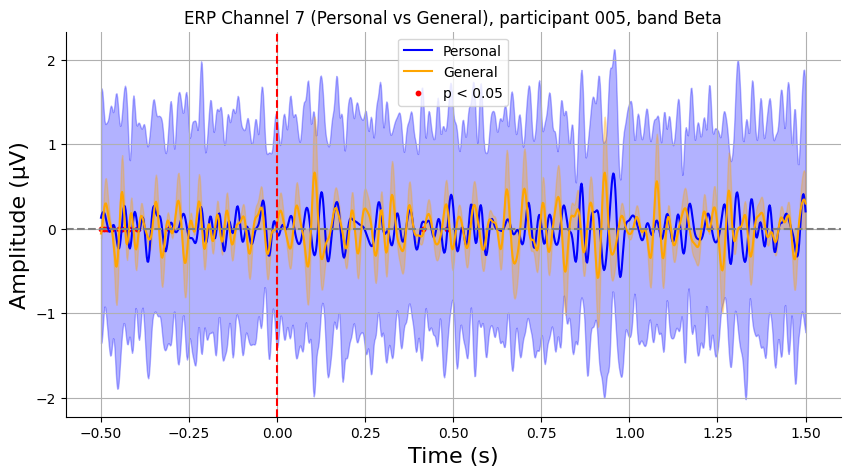

channel: 3


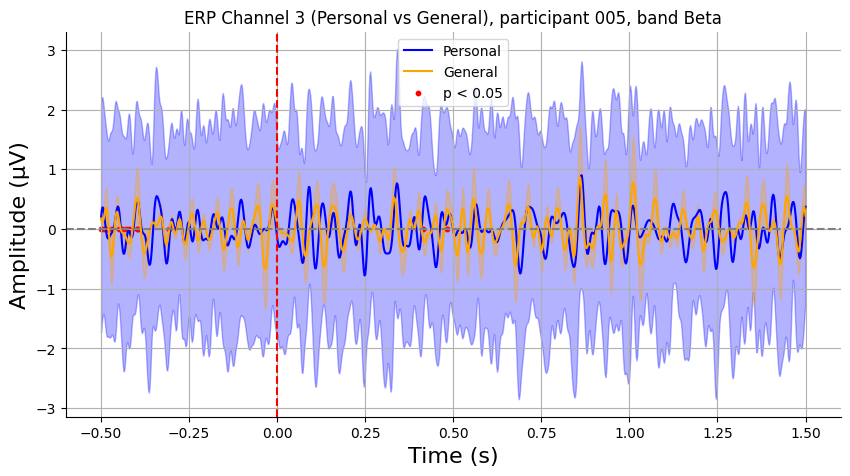

channel: 17


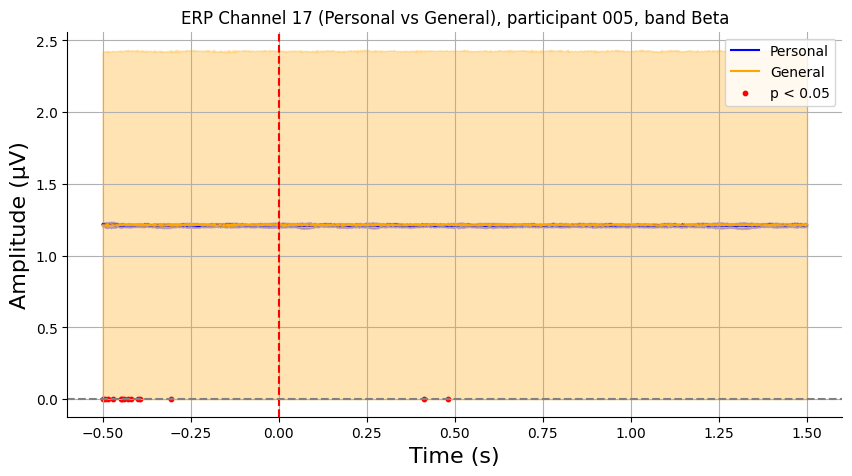

channel: 14


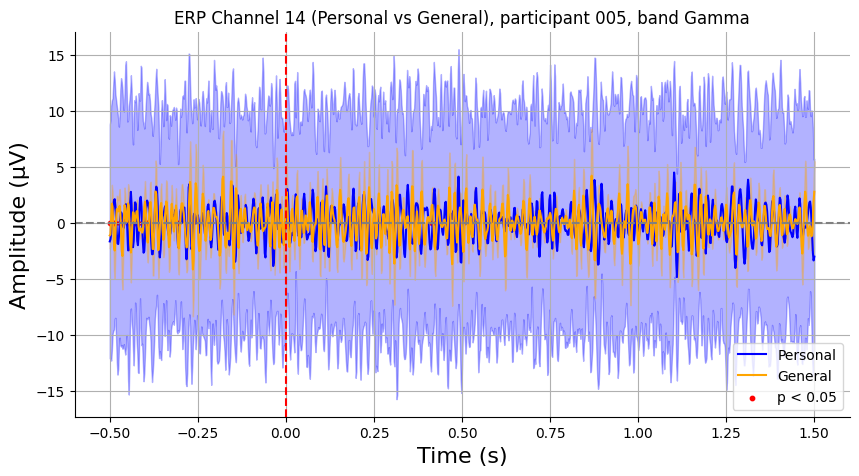

channel: 8


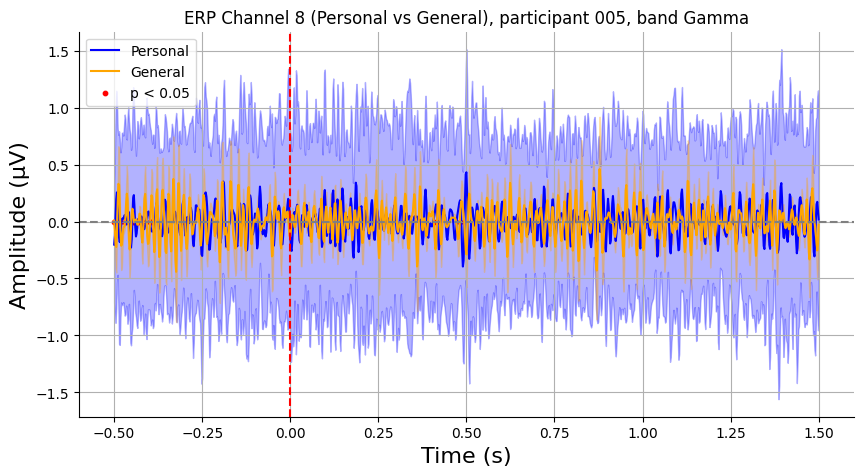

channel: 7


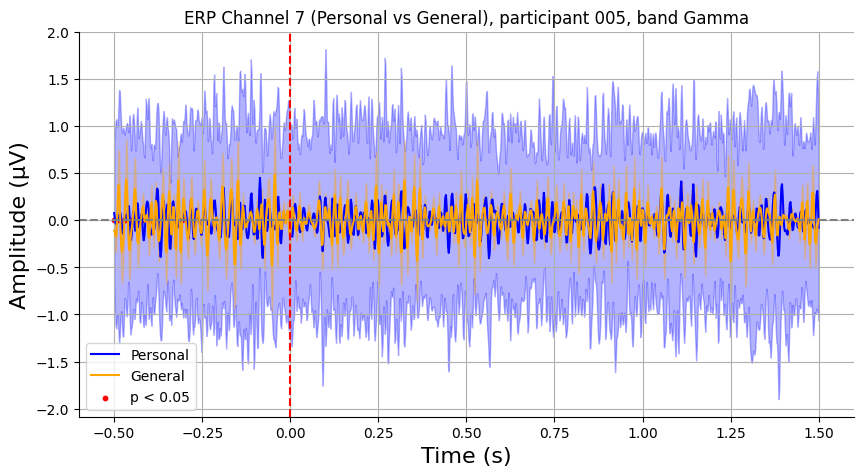

channel: 3


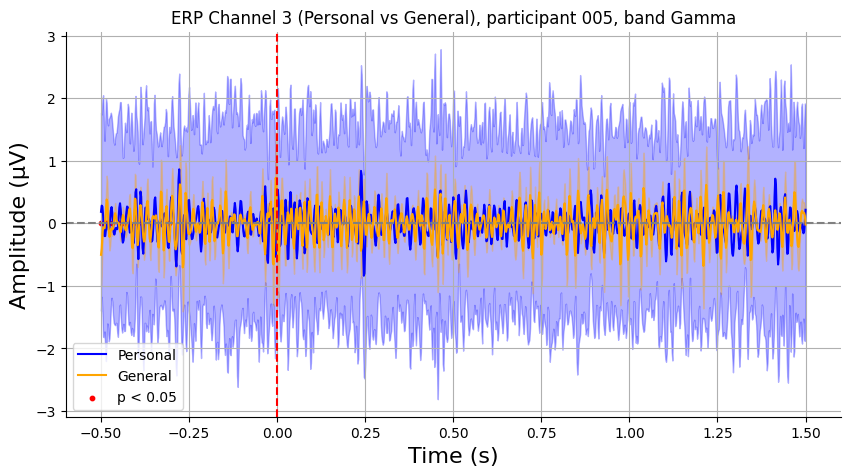

channel: 17


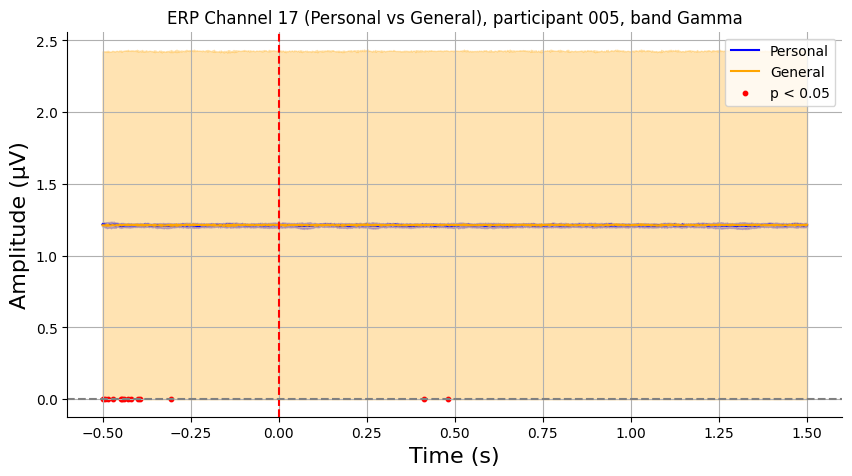

channel: 14


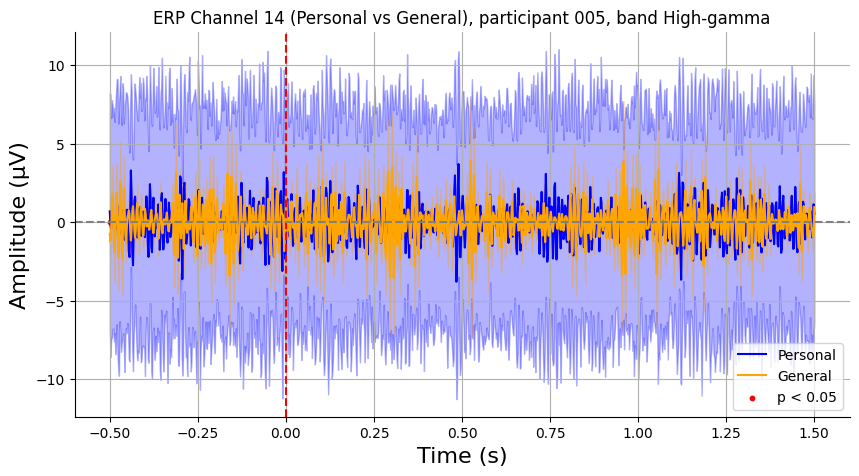

channel: 8


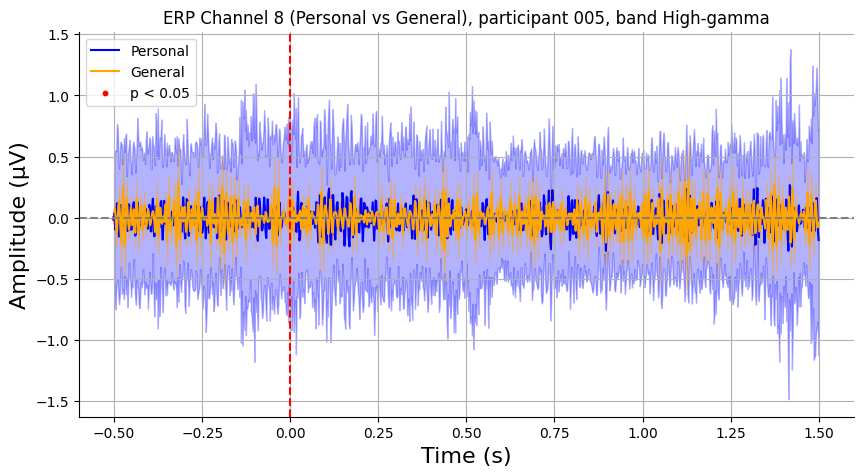

channel: 7


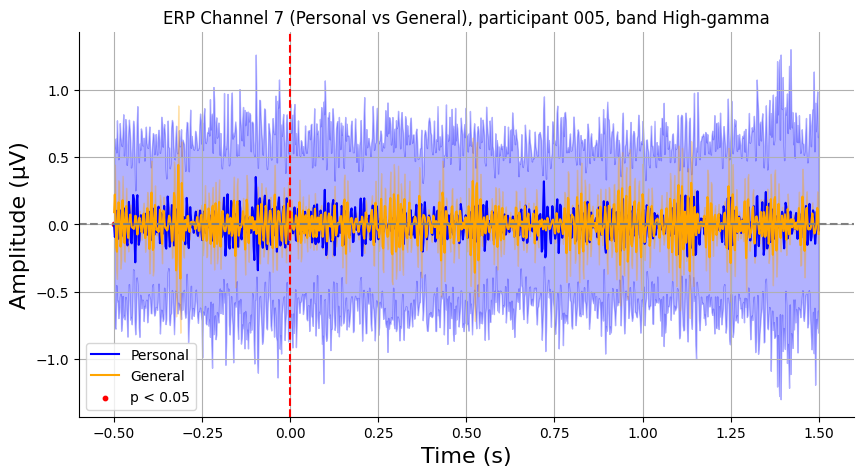

channel: 3


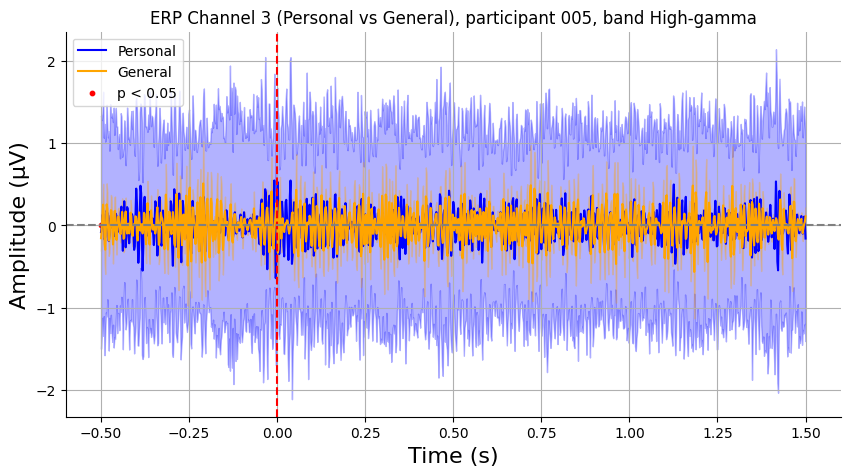

channel: 17


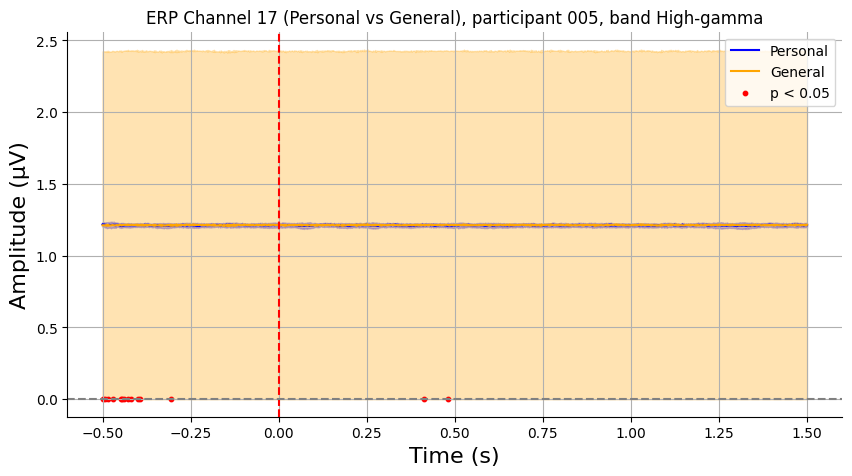

In [128]:
#create significance masks
print(stats['Delta']['p_values'][1] < 0.05)
save_path = 'figures_2/erp_channels'
os.makedirs(save_path, exist_ok=True)
times = np.linspace(-0.5, 1.5, n_times)

relevant_channels = {}
for band in stats:
    relevant_channels[band] =  []
    for ch in range(n_channels):
        stats[band]['sig_mask'] = stats[band]['p_values'][ch] < 0.05
        #print(stats[band]['p_values'].shape)
        #count number of significant points to plot most significant plots
        sig_counts = np.sum(stats[band]['p_values'] < 0.05, axis=1)  # shape: (n_channels,)
        #collect top n most significant channels to plot
        top_n = 5
        most_sig_channels = np.argsort(-sig_counts)[:top_n]

        relevant_channels[band] = most_sig_channels
print(relevant_channels)
        

#plot only the most significant channels
for band in relevant_channels:
    for ch in relevant_channels[band]:
        print(f'channel: {ch}')
        fig, ax = plt.subplots(figsize=(10, 5))
        #print(times.shape, erps[band]['personal'][ch].shape)
        
        ax.plot(times, mean_erps[band]['personal'][ch], label='Personal', color='blue')
        ax.plot(times, mean_erps[band]['general'][ch], label='General', color='orange')
        ax.fill_between(times,
                 mean_erps[band]['personal'][ch] - std_erps[band]['personal'][ch],
                 mean_erps[band]['personal'][ch] + std_erps[band]['personal'][ch],
                 color='blue', alpha=0.3)

        ax.fill_between(times,
                 mean_erps[band]['general'][ch] - std_erps[band]['general'][ch],
                 mean_erps[band]['general'][ch] + std_erps[band]['general'][ch],
                 color='orange', alpha=0.3)

        ax.scatter(times[stats[band]['sig_mask']], [0]*np.sum(stats[band]['sig_mask']), color='red', s=10, label='p < 0.05')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
        ax.set_title(f'ERP Channel {ch} (Personal vs General), participant {participant}, band {band}')
        ax.set_xlabel('Time (s)', fontsize=16)
        ax.set_ylabel('Amplitude (µV)', fontsize=16)
        ax.axhline(0, linestyle='--', color='gray')
        ax.legend()
        ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_position(('outward', 100))  # Add padding to the bottom
        ax.spines['right'].set_position(('outward', 100)) 
        plt.savefig(f'{save_path}/{participant}_erp_channel_{ch}.png', dpi=300)
        plt.show()
        plt.close()
